# Document Retrieval (40 pts)

Information Retrieval involves the process of obtaining information from a system based on an information
need. One example is to obtain documents relevant to a user query from a large corpus of documents. The
vector space model models these documents as vectors that represent these documents. A query can be
represented as another vector. We can now find similar documents to a query by using some form of distance
in the vector space, like cosine similarity: <br><br>

$$cosine\,similarity = cos(\theta) = \frac{q \cdot d}{\|q\| \|d\|}$$

where **q** and **d** are the query and document vectors respectively.
How are these vector space models built? Let us represent a corpus of documents as a term-document matrix.
A term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a
collection of documents. In a document-term matrix, rows correspond to documents in the collection and
columns correspond to terms. The entries in the matrix can be defined in different ways (we will describe
a few variations in this assignment question). A term document matrix allows for a way to index several
documents against which a user query can be compared to fetch relevant documents.  

Consider a corpus of documents:  



*   I AM JILL
*   I ADORE JILL OH SO STILL
*   I ADORE CHOCO BAR AND CHILL



## Problem 1. Simple Word Counts (15 pts)

**You will have 3 sub-problems in this section.**

You will create a simple Term-Document Matrix based on the Counting Method here.

In [1]:
import numpy as np
import nltk
import scipy as sp
from nltk.tokenize import word_tokenize
import pandas as pd
import sys
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/sungwoopark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
corpus=["I AM JILL",
"I ADORE JILL OH SO STILL I AM",
"I ADORE CHOCO BAR AND CHILL"]

### Problem 1 (a) 
(5 pts)
Create a term document matrix using simple word counts (number of times a word appears in a document) for all the documents

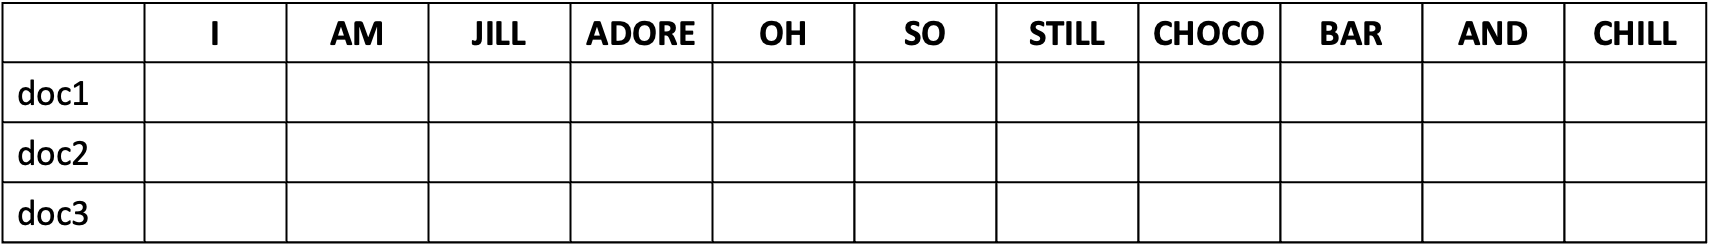

In [3]:
def simple_word_counts(corpus:list[str]) -> np.ndarray:
    """ Create a term-document matrix using simple word counts

    Arguments:
    corpus -- list of sentences in the corpus

    Return:
    term_doc_matrix -- term-document matrix where each element is the number of times a word appears in a document. The order of words DOES NOT matter.
    """
    term_doc_matrix=np.zeros([3, 11])

    #### YOUR CODE HERE (~ 6 lines) ####
    column_maps = {'I': 0, "AM": 1, "JILL": 2, "ADORE": 3, "OH": 4, "SO": 5, 
                   "STILL": 6, "CHOCO": 7, "BAR": 8, "AND": 9, "CHILL": 10}
    for i, text in enumerate(corpus):
        tokens = word_tokenize(text)
        for token in tokens:
            token_col_idx = column_maps[token]
            term_doc_matrix[i][token_col_idx] += 1
    #### YOUR CODE HERE ####
    return term_doc_matrix

In [4]:
simple_word_counts(corpus)

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.]])

### Problem 1 (b)
(5 pts)
Using the vector space model and cosine similarity find the closest document to the user query ”I ADORE CHILL”.

Please complete the following function to return the closest sentence with Term Frequency and its Cosine Similarity with the given query.

In [5]:
def cos_distance(a:np.ndarray, b:np.ndarray) -> float:
    return 1 - sp.spatial.distance.cosine(a, b)

def find_the_closest_document(corpus: list[str], query: str) :
    """ Find the closest document with query from corpus

    Arguments:
    corpus -- list of sentences in the corpus
    query -- a string to compute cosine similarity with

    Return:
    closest_document -- the string in the corpus which is the closest to the query
    max_similarity -- the cosine similarity between the query and the closest corpus
    """
    closest_document = str()
    max_similarity = -1
    #### YOUR CODE HERE ####
    # build the term frequency space using the simple_word_counts above
    query_vector = simple_word_counts([query])[0, :]
    corpus_vector = simple_word_counts(corpus)
    
    for i, text in enumerate(corpus):
        text_vector = corpus_vector[i, :]
        similarity = cos_distance(text_vector, query_vector)
        # update the similarity and the closest document
        if max_similarity < similarity:
            max_similarity = similarity
            closest_document = text
    #### make use of cos_distance function above!

    return closest_document, max_similarity

In [6]:
query="I ADORE CHILL"
find_the_closest_document(corpus, query)

('I ADORE CHOCO BAR AND CHILL', 0.7071067811865476)

### Problem 1 (c) 
(5 pts)
What are some issues you see of using counts to create the document vector?

Answer : Some notable issues are listed below:

* Sparse Vectors: For large vocabularies, most of the entries in the vector will be zero, leading to high-dimensional, sparse vectors. This can be computationally intensive and memory-inefficient.

* High Frequency Words: Common words, such as "and", "the", "is", that appear in most documents will have high frequencies but don't necessarily contribute meaningful information. This could underestimate the effects of more relevant, less frequent words.

* Scalability Issues: As the vocabulary grows, the vector representation for each document grows linearly, which may not be scalable for extremely large corpora.

* Lack of Semantic Meaning: Raw counts don't capture the semantic meaning of words. For instance, two documents might use different words with the same or similar meanings, and the simple count method wouldn't recognize their similarity.

## Problem 2. TF-IDF (25 pts)

**You will 4 sub-problem in this section.**

One solution to this problem is to use the TF-IDF representation. TF-IDF involves multiplying the term
frequency (which can be the raw counts) with an inverse document frequency (idf). The inverse document
frequency is a measure of how much information the word provides, i.e., if it is common or rare across all
documents. It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained
by dividing the total number of documents by the number of documents containing the term, and then taking
the logarithm of that quotient).  <br><br>

$$\operatorname{idf}(t) = \log_2 \frac{\text{(Number of documents in the corpus)}}{\text{(Number of documents } t \text{ appears in)}}$$  
  <br>
  
$$\operatorname{tf-idf} = \operatorname{tf} \times \operatorname{idf}$$
<br>

### Problem 2 (a)
(8 pts)
Now instead of using the raw counts, use TF-IDF for each entry in the term-document matrix. Using the vector space model and cosine similarity find the closest document to the user query “I ADORE CHILL” for the new index.

Please complete the following function to return the closest sentence with TF-IDF and its Cosine Similarity with the given query.

In [7]:
def log2(x):
    return np.log(x) / np.log(2)

def idf(corpus:list[str], term:str):
    numerator = len(corpus)
    cnt = 0
    for doc in corpus:
        if term in doc:
            cnt += 1
    return log2(numerator / cnt)

def tf_idf(corpus:list[str], query:str):
    column_maps = {'I': 0, "AM": 1, "JILL": 2, "ADORE": 3, "OH": 4, "SO": 5, 
                   "STILL": 6, "CHOCO": 7, "BAR": 8, "AND": 9, "CHILL": 10}
    tf = simple_word_counts([query])[0, :]
    doc_tokens = word_tokenize(query)
    for token in doc_tokens:
        idx = column_maps[token]
        idf_token = idf(corpus, token)
        tf[idx] *= idf_token
    return tf

In [8]:
def find_the_closest_document_tfidf(corpus: list[str], query: str) :
    """ Find the closest document with query from corpus using tf-idf

    Arguments:
    corpus-- list of sentences in the corpus
    query-- a string to compute cosine similarity with

    Return:
    closest_document --the string in the corpus which is the closest to the query
    max_similarity --the cosine similarity between the query and the closest corpus
    """
    closest_document = str()
    max_similarity = -1

    #### YOUR CODE HERE ####
    query_tf_idf = tf_idf(corpus, query)
    for doc in corpus:
        doc_tf_idf = tf_idf(corpus, doc)
        similarity = cos_distance(query_tf_idf, doc_tf_idf)
        if max_similarity < similarity:
            max_similarity = similarity
            closest_document = doc
    
    #### NOTE the base of log is 2, not 10 or e

    return closest_document, max_similarity

In [9]:
query="I ADORE CHILL"
find_the_closest_document_tfidf(corpus, query)

('I ADORE CHOCO BAR AND CHILL', 0.5241171950497726)

### Problem 2 (b)
(5 pts)
How does TF-IDF solve the issue quoted in Problem 1?

Answer :
1. Discrimination Between Terms
    - By multiplying TF by IDF, common terms that are frequent across many documents (e.g., stop words) are down-weighted. This means that terms that are frequent in a particular document but not in most other documents get a higher weight, making them more discriminative.

2. Normalization
    - TF-IDF vectors are often normalized (e.g., L2 normalization), which reduces the bias towards longer documents. This ensures that the similarity measure gives importance to the content and distribution of terms, rather than the sheer length of the document.

3. Emphasis on Informative Terms
    - By nature, the IDF component gives more weight to terms that are rare across the corpus but might be frequent in a specific document. This ensures that these discriminative terms play a significant role in the resulting vector representation, emphasizing the unique content of each document.

### Problem 2 (c)
(7 pts)
Instead of using cosine similarity we could also use the L2 distance.   

Please complete the following function to return the closest sentence with TF-IDF and its L2 distance with the given query.

In [10]:
def l2norm(v:np.ndarray):
    return np.sqrt(np.sum(v ** 2))

def l2distance(a:np.ndarray, b:np.ndarray):
    return l2norm(a - b)

In [11]:
def find_the_closest_document_L2(corpus: list[str], query: str) :
    """ Find the closest document with query from corpus using L2 distance

    Arguments:
    corpus-- list of sentences in the corpus
    query-- a string to compute cosine similarity with

    Return:
    closest_document --the string in the corpus which is the closest to the query
    min_dist --the L2 distance between the query and the closest corpus
    """
    closest_document = str()
    min_dist = float('inf')

    #### YOUR CODE HERE ####
    query_tf_idf = tf_idf(corpus, query)
    for doc in corpus:
        doc_tf_idf = tf_idf(corpus, doc)
        distance = l2distance(query_tf_idf, doc_tf_idf)
        if min_dist > distance:
            min_dist = distance
            closest_document = doc

    ########################
    return closest_document, min_dist

In [12]:
query="I ADORE CHILL"
find_the_closest_document_L2(corpus, query)

('I AM JILL', 1.881129849436797)

### Problem 2 (d)

(5 pts) Which similarity function (L2 or cosine) would work better here?

Answer : In my opinion, the cosine similarity works better here for the following reasons:
1. Zero-vector Issue
    - In some cases, if a term from the query isn't present in any of the documents, its IDF becomes infinite, leading to zero vectors in TF-IDF representations. L2 distance isn't meaningful for zero vectors.
    - Cosine similarity handles zero vectors gracefully. If one of the vectors is a zero-vector, the cosine similarity is zero.


2. Interpretability:
    - Cosine similarity values range between -1 (for completely dissimilar) and 1 (for identical). A value of 0 indicates orthogonality or decorrelation. For text data, since negative values don't occur in TF-IDF vectors, the range is typically between 0 (no similarity) and 1 (identical).
    - L2 distance can range from 0 to infinity, with smaller values indicating similarity and larger values indicating dissimilarity. However, the range of possible values is not fixed, which can make direct comparisons or thresholds less intuitive.
    
Overall, the cosine similarity would work better due to its robustness and intuitivity.